In [2]:

# Imports
import sys
import importlib

import pandas as pd
from textblob import TextBlob

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sys.path.append("..")

import ds_helpers as dh
import helper_funcs as hf
import ml_models as ml

In [3]:
importlib.reload(dh)
importlib.reload(hf)
importlib.reload(ml)

# Fetch all datasets
news_path = "/../../news_data/"
stock_path = "/../../stock_data/"

news_df, stock_meta = dh.fetch_datasets(news_path, stock_path)
stock_dfs = dh.fetch_stock_data(stock_meta, stock_path)

# Prepare datasets
stock_dfs = dh.prep_stock_data(stock_dfs)
news_df = dh.prep_news_data(news_df, stock_dfs)

# Sentiment Analysis
daily_sent = ml.sentiment_analysis(news_df)

Error retrieving stock: AGM$A
Error retrieving stock: CARR.V
Error retrieving stock: UTX.V

Dropping VST: invalid 1 day return

Number of Stocks before processing: 	5881
Number of Stocks after processing: 	3284



In [4]:
importlib.reload(dh)
importlib.reload(hf)
importlib.reload(ml)

big_df = ml.dataframe_union(stock_dfs, daily_sent)

In [5]:
x_features = ['Open'] + list(news_df['category'].unique())
X = big_df[x_features]

y_0d = big_df['r_0d']
y_1d = big_df['r_1d']
y_7d = big_df['r_7d']
y_30d = big_df['r_30d']

N_EST = 1000
LAMBDA = 0.05
MAX_DEPTH = 6
SUB_SAMP = 0.8
OBJECTIVE = "reg:squarederror"
METHOD = "hist"

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_0d, test_size=0.2, random_state=42)

model_0d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD
)

model_0d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_0d = model_0d.evals_result()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_1d, test_size=0.2, random_state=42)

model_1d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD
)

model_1d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_1d = model_1d.evals_result()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_7d, test_size=0.2, random_state=42)

model_7d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD
)

model_7d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_7d = model_7d.evals_result()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_30d, test_size=0.2, random_state=42)

model_30d = xgb.XGBRegressor(
    n_estimators = N_EST,
    learning_rate = LAMBDA,
    max_depth = MAX_DEPTH,
    subsample = SUB_SAMP,
    objective = OBJECTIVE,
    tree_method = METHOD
)

model_30d.fit(
    X_train, 
    y_train,
    eval_set=[(X_test,y_test)],
    verbose=False
)

evals_30d = model_30d.evals_result()

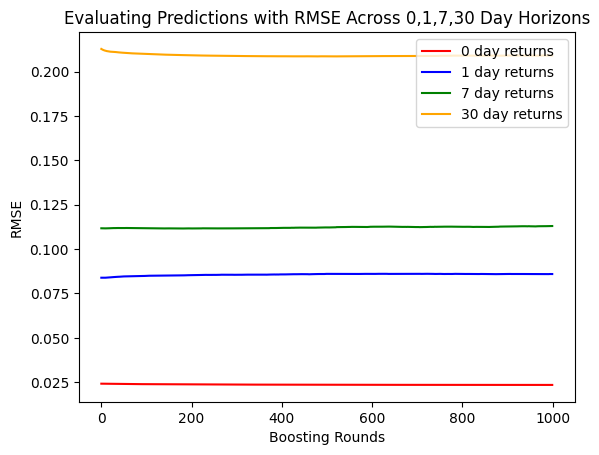

In [30]:
import matplotlib.pyplot as plt

plt.plot(evals_0d['validation_0']['rmse'], color='red', label='0 day returns')
plt.plot(evals_1d['validation_0']['rmse'], color='blue', label='1 day returns')
plt.plot(evals_7d['validation_0']['rmse'], color='green', label='7 day returns')
plt.plot(evals_30d['validation_0']['rmse'], color='orange', label='30 day returns')

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Evaluating Predictions with RMSE Across 0,1,7,30 Day Horizons')
plt.legend()

plt.show()